In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform


In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, labels = mnist.data, mnist.target.astype(int)

N = 10000
X, labels = X[:N], labels[:N]

X = X / 255.0

X -= np.mean(X, axis=0)

print(f"Shape of X after preprocessing: {X.shape}") 

Shape of X after preprocessing: (10000, 784)


In [3]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

print(f"Shape of X after PCA: {X_pca.shape}")


Shape of X after PCA: (10000, 50)


In [ ]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

print("PCA Shape: ", X_pca.shape)

PCA Shape:  (5000, 50)


In [4]:
D = squareform(pdist(X_pca, 'euclidean'))
print(f"Shape of D: {D.shape}")


Shape of D: (10000, 10000)


In [5]:
def compute_p_matrix(D, perplexity=30.0):
    N = D.shape[0]
    P = np.zeros((N, N))
    beta = np.ones(N) * 0.6
    log_perp = np.log2(perplexity)

    for i in range(N):
        betamin, betamax = -np.inf, np.inf
        trials = 0
        H_diff = 1

        while abs(H_diff) > 1e-5 and trials < 50:
            P_i = np.exp(-D[i] * beta[i])
            P_i[i] = 0
            sum_P_i = np.sum(P_i)
            if sum_P_i == 0:
                sum_P_i = 1
            P_i /= sum_P_i

            H = -np.sum(P_i * np.log2(P_i + 1e-10))
            H_diff = H - log_perp

            if H_diff > 0:
                betamin = beta[i]
                beta[i] = (betamax + beta[i]) / 2 if betamax != np.inf else beta[i] * 2
            else:
                betamax = beta[i]
                beta[i] = (betamin + beta[i]) / 2 if betamin != -np.inf else beta[i] / 2
            
            trials += 1
        
        P[i] = P_i

    return P

P = compute_p_matrix(D)
P = (P + P.T) / (2 * np.sum(P))

print(f"Shape of P: {P.shape}")


Shape of P: (10000, 10000)


In [6]:
no_dims = 2
y = 0.0001 * np.random.randn(N, no_dims)
y_incs = np.zeros_like(y)
gains = np.ones_like(y)

max_iter = 400
epsilon = 500
min_gain = 0.01

print(f"Shape of Y: {y.shape}")


Shape of Y: (10000, 2)


/var/folders/mg/w4cw2nc563q822jj2x4x_qqh0000gn/T/ipykernel_2153/805138099.py:19: RuntimeWarning: divide by zero encountered in log
  cost = np.sum(P * np.log(P / (Q + 1e-10)))  # KL Divergence
/var/folders/mg/w4cw2nc563q822jj2x4x_qqh0000gn/T/ipykernel_2153/805138099.py:19: RuntimeWarning: invalid value encountered in multiply
  cost = np.sum(P * np.log(P / (Q + 1e-10)))  # KL Divergence


Iteration 100: error = nan


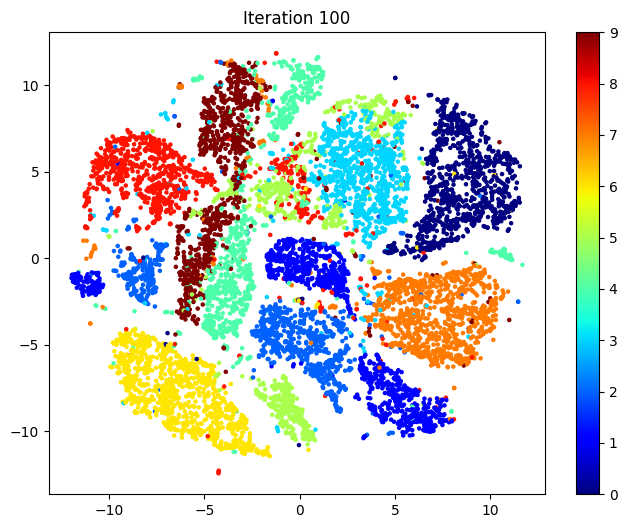

Iteration 200: error = nan


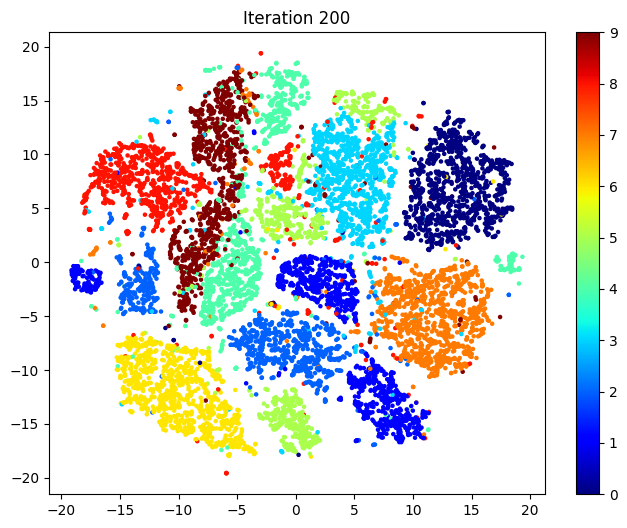

Iteration 300: error = nan


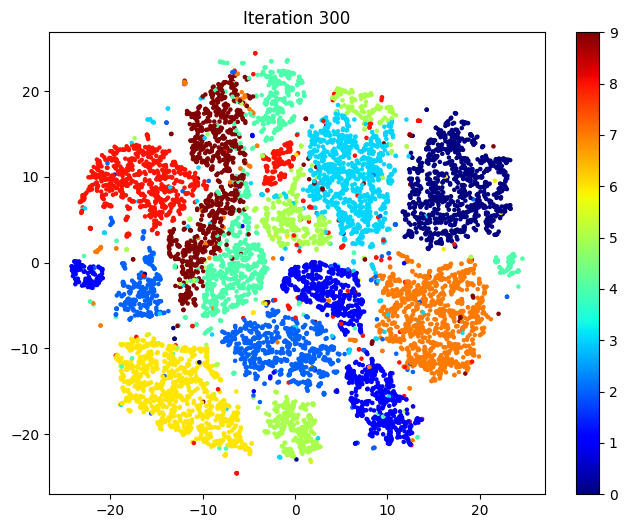

Iteration 400: error = nan


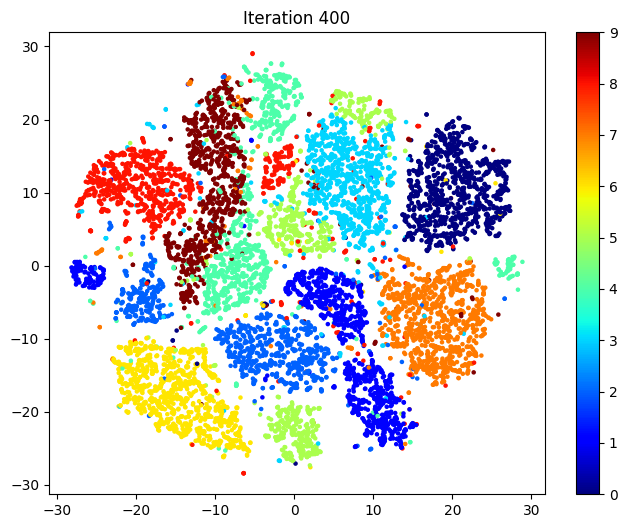

In [7]:
for iter in range(1, max_iter + 1):
    sum_y2 = np.sum(y ** 2, axis=1)
    Qnum = 1 / (1 + np.add.outer(sum_y2, sum_y2) - 2 * np.dot(y, y.T))
    np.fill_diagonal(Qnum, 0)

    Q = Qnum / np.sum(Qnum)
    L = (P - Q) * Qnum
    y_grads = 4 * (np.diag(np.sum(L, axis=1)) - L) @ y

    gains = (gains + 0.2) * (np.sign(y_grads) != np.sign(y_incs)) + (gains * 0.8) * (np.sign(y_grads) == np.sign(y_incs))
    gains[gains < min_gain] = min_gain
    y_incs = -epsilon * (gains * y_grads)
    y += y_incs
    y -= np.mean(y, axis=0)

    if iter % 100 == 0:
        cost = np.sum(P * np.log(P / (Q + 1e-10)))
        print(f"Iteration {iter}: error = {cost}")

        plt.figure(figsize=(8, 6))
        plt.scatter(y[:, 0], y[:, 1], c=labels, cmap='jet', s=5)
        plt.colorbar()
        plt.title(f"Iteration {iter}")
        plt.show()
